<a href="https://colab.research.google.com/github/pranee31/Mettur-dam-water-level-prediction/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'revised mettur_dam_data.csv'
dam_data = pd.read_csv(file_path)

# Step 1: Handle missing values
# Fill numeric missing values with the median of the column
numeric_columns = dam_data.select_dtypes(include=[np.number]).columns
dam_data[numeric_columns] = dam_data[numeric_columns].fillna(dam_data[numeric_columns].median())

# Fill categorical missing values with the mode of the column
categorical_columns = dam_data.select_dtypes(include=[object]).columns
dam_data[categorical_columns] = dam_data[categorical_columns].fillna(dam_data[categorical_columns].mode().iloc[0])

# Step 2: Convert date columns to datetime format
dam_data['datetime'] = pd.to_datetime(dam_data['datetime'], errors='coerce')
dam_data['Date'] = pd.to_datetime(dam_data['Date'], errors='coerce')

# Step 3: Drop unnecessary columns
# Retain 'Full Capacity (M.Cft.)' but drop other irrelevant columns
columns_to_drop = ['name', 'Reservoir Name', 'stations', 'description', 'icon']
dam_data = dam_data.drop(columns=columns_to_drop, axis=1)

# Step 4: Ensure all data is numeric where required
# Convert "Current Year Outflow (CuSecs)" to numeric
# Convert 'Full Capacity (M.Cft.)' column to float
dam_data['Full Capacity (M.Cft.)'] = dam_data['Full Capacity (M.Cft.)'].replace({',': ''}, regex=True)
dam_data['Full Capacity (M.Cft.)'] = pd.to_numeric(dam_data['Full Capacity (M.Cft.)'], errors='coerce')


dam_data['Current Year Outflow (CuSecs)'] = pd.to_numeric(dam_data['Current Year Outflow (CuSecs)'], errors='coerce')

# Fill numeric columns with their median value
for col in numeric_columns:
    if col in dam_data.columns:
        dam_data[col] = dam_data[col].fillna(dam_data[col].median())

# Step 5: Extract relevant features
# Adding 'Full Capacity (M.Cft.)' to the feature list
features = [
    'tempmax', 'tempmin', 'temp', 'humidity', 'precip',
    'Current Year Inflow (CuSecs)', 'Current Year Outflow (CuSecs)',
    'Full Capacity (M.Cft.)', 'Current Year Storage (M.Cft.)'
]
target = 'Current Year Storage (M.Cft.)'  # Predict future storage

# Filter dataset for features and target
dam_data = dam_data[features]

# Display cleaned dataset information
dam_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2716 entries, 0 to 2715
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tempmax                        2716 non-null   float64
 1   tempmin                        2716 non-null   float64
 2   temp                           2716 non-null   float64
 3   humidity                       2716 non-null   float64
 4   precip                         2716 non-null   float64
 5   Current Year Inflow (CuSecs)   2716 non-null   float64
 6   Current Year Outflow (CuSecs)  2715 non-null   float64
 7   Full Capacity (M.Cft.)         2716 non-null   int64  
 8   Current Year Storage (M.Cft.)  2716 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 191.1 KB


In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = dam_data.drop(columns=['Current Year Storage (M.Cft.)'], axis=1)
y = dam_data['Current Year Storage (M.Cft.)']

# Split data into training and testing sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of training and testing sets
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing set: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training set: X_train: (2172, 8), y_train: (2172,)
Testing set: X_test: (544, 8), y_test: (544,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Print model training completion
print("Model training complete.")


Model training complete.


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2}")
print(f"Mean Absolute Error: {mae}")


R² Score: 0.8362737479808993
Mean Absolute Error: 6276.981712622549


In [ ]:

import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd

# Function to fetch current dam data
def fetch_current_dam_data(date):
    url = f"http://tnagriculture.in/ARS/home/reservoir/{date}"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract relevant details (adjust selectors based on the HTML structure)
    current_data = {
        'Current Year Storage (M.Cft.)': None,
        'Current Year Inflow (CuSecs)': None,
        'Current Year Outflow (CuSecs)': None,
        'Full Capacity (M.Cft.)': None,
    }

    try:
        # Assuming data is in table rows, customize this as per actual structure
        table_rows = soup.find_all('tr')
        row=table_rows[1]
        cells = row.find_all('td')
        if len(cells) > 1:
            if 'Current Year Storage (M.Cft.)' in cells[4].text:
                current_data['Current Year Storage (M.Cft.)'] = float(cells[1].text.replace(',', ''))
            elif 'Current Year Inflow (CuSecs)' in cells[5].text:
                current_data['Current Year Inflow (CuSecs)'] = float(cells[1].text.replace(',', ''))
            elif 'Current Year Outflow (CuSecs)' in cells[6].text:
                current_data['Current Year Outflow (CuSecs)'] = float(cells[1].text.replace(',', ''))
            elif 'Full Capacity (M.Cft.)' in cells[2].text:
                current_data['Full Capacity (M.Cft.)'] = float(cells[1].text.replace(',', ''))
    except Exception as e:
        print(f"Error fetching dam data: {e}")

    return current_data
# Function to fetch future weather data
def fetch_weather_data(date1, date2):
    api_key = "GUPPEYKJKWWQKWXWR2V97VVHC"
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/mettur/{date1}/{date2}?key={api_key}"
    response = requests.get(url)

    if response.status_code == 200:
        weather_data = response.json()
        # Extract relevant weather details for the target date
        future_weather = {
            'tempmax': weather_data['days'][0]['tempmax'],
            'tempmin': weather_data['days'][0]['tempmin'],
            'temp': weather_data['days'][0]['temp'],
            'humidity': weather_data['days'][0]['humidity'],
            'precip': weather_data['days'][0]['precip']
        }
        return future_weather
    else:
        print(f"Error fetching weather data: {response.status_code}")
        return None


In [ ]:
def predict_future_storage(date, model):
    # Fetch current dam data
    current_dam_data = fetch_current_dam_data(date)
    if not current_dam_data:
        print("Failed to fetch dam data.")
        return None

    # Fetch future weather data
    future_weather_data = fetch_weather_data(date, date)
    if not future_weather_data:
        print("Failed to fetch weather data.")
        return None

    # Combine all data into a single input
    input_data = {
        **current_dam_data,
        **future_weather_data
    }

    # Ensure all required features are present
    feature_order = [
        'tempmax', 'tempmin', 'temp', 'humidity', 'precip',
        'Current Year Inflow (CuSecs)', 'Current Year Outflow (CuSecs)',
        'Full Capacity (M.Cft.)'
    ]
    input_values = [input_data[feature] for feature in feature_order]

    # Make prediction
    prediction = model.predict([input_values])[0]
    print(f"Predicted Water Storage on {date}: {prediction} M.Cft.")
    return prediction


In [ ]:
# Function to allow user input for the future date
def get_future_date():
    future_date = input("Please enter the future date (YYYY-MM-DD): ")
    return future_date

# Main function to predict future storage
def predict_future_storage(future_date, model):
    # Assuming you already have code to prepare the data and use the model for prediction
    print(f"Predicting storage for the date: {future_date}")
    # Fetch current dam data
    current_dam_data = fetch_current_dam_data(future_date)
    print(current_dam_data)
    if not current_dam_data:
        print("Failed to fetch dam data.")
        return None

    # Fetch future weather data
    future_weather_data = fetch_weather_data(future_date, future_date)
    if not future_weather_data:
        print("Failed to fetch weather data.")
        return None

    # Combine all data into a single input
    input_data = {
        **current_dam_data,
        **future_weather_data
    }

    # Ensure all required features are present
    feature_order = [
        'tempmax', 'tempmin', 'temp', 'humidity', 'precip',
        'Current Year Inflow (CuSecs)', 'Current Year Outflow (CuSecs)',
        'Full Capacity (M.Cft.)'
    ]
    input_values = [input_data[feature] for feature in feature_order]

    # Make prediction
    prediction = model.predict([input_values])[0]
    print(f"Predicted Water Storage on {future_date}: {prediction} M.Cft.")
    return prediction
# Get user input
future_date = get_future_date()

# Call the function with the entered future date
predict_future_storage(future_date, model)


Please enter the future date (YYYY-MM-DD): 2025-12-04
Predicting storage for the date: 2025-12-04
{'Current Year Storage (M.Cft.)': None, 'Current Year Inflow (CuSecs)': None, 'Current Year Outflow (CuSecs)': None, 'Full Capacity (M.Cft.)': None}
Predicted Water Storage on 2025-12-04: 90963.66 M.Cft.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


90963.66

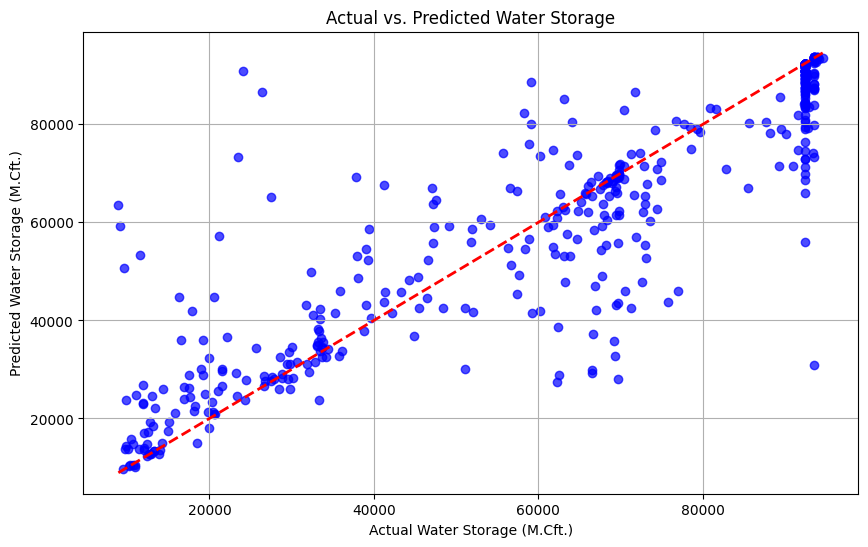

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot for Actual vs. Predicted Water Storage
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.title('Actual vs. Predicted Water Storage')
plt.xlabel('Actual Water Storage (M.Cft.)')
plt.ylabel('Predicted Water Storage (M.Cft.)')
plt.grid(True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', linewidth=2)
plt.show()


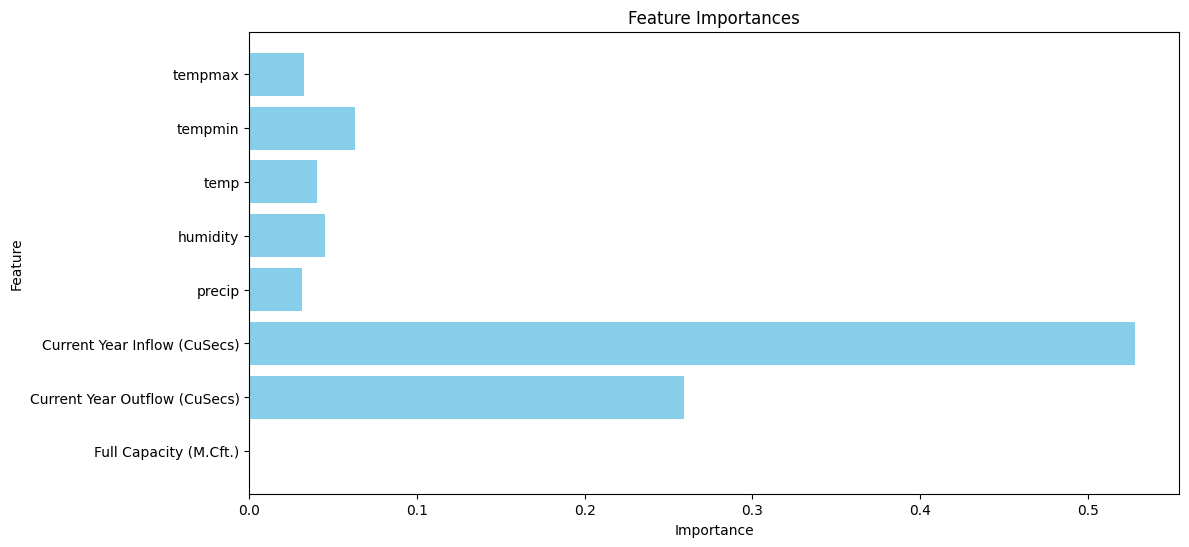

In [ ]:
# Feature importances plot
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(12, 6))
plt.barh(features, importances, color='skyblue')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import pandas as pd

# Assuming your data starts from '2010-01-01' and has daily frequency
dam_data['Date'] = pd.date_range(start='2010-01-01', periods=len(dam_data), freq='D')

# Ensure 'Date' is in datetime format
dam_data['Date'] = pd.to_datetime(dam_data['Date'], errors='coerce')

# Check if the 'Date' column has been added successfully
print(dam_data.head())


   tempmax  tempmin  temp  humidity  precip  Current Year Inflow (CuSecs)  \
0     94.7     73.6  83.7      69.6   0.020                        2886.0   
1     93.8     74.6  83.5      67.0   0.114                        2886.0   
2     88.8     75.1  81.8      68.1   0.139                        2886.0   
3     91.1     74.0  82.5      69.1   0.063                        2886.0   
4     92.6     75.6  83.1      70.4   0.201                        2886.0   

   Current Year Outflow (CuSecs)  Full Capacity (M.Cft.)  \
0                          803.0                   93470   
1                          803.0                   93470   
2                          803.0                   93470   
3                          803.0                   93470   
4                          803.0                   93470   

   Current Year Storage (M.Cft.)       Date  
0                          92391 2010-01-01  
1                          92391 2010-01-02  
2                          92391 2010-

In [ ]:
# Generate a 'Date' column with daily frequency
dam_data['Date'] = pd.date_range(start='2010-01-01', periods=len(dam_data), freq='D')



# Ensure 'Date' is in datetime format
dam_data['Date'] = pd.to_datetime(dam_data['Date'], errors='coerce')

# Check the DataFrame
print(dam_data.head())


   tempmax  tempmin  temp  humidity  precip  Current Year Inflow (CuSecs)  \
0     94.7     73.6  83.7      69.6   0.020                        2886.0   
1     93.8     74.6  83.5      67.0   0.114                        2886.0   
2     88.8     75.1  81.8      68.1   0.139                        2886.0   
3     91.1     74.0  82.5      69.1   0.063                        2886.0   
4     92.6     75.6  83.1      70.4   0.201                        2886.0   

   Current Year Outflow (CuSecs)  Full Capacity (M.Cft.)  \
0                          803.0                   93470   
1                          803.0                   93470   
2                          803.0                   93470   
3                          803.0                   93470   
4                          803.0                   93470   

   Current Year Storage (M.Cft.)       Date  
0                          92391 2010-01-01  
1                          92391 2010-01-02  
2                          92391 2010-

Fine Tuning

In [ ]:
dam_data.fillna(dam_data.mean(), inplace=True)  # Example for filling missing values


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", scores)


Cross-Validation R² Scores: [ 0.34700373  0.67659906 -0.21563268 -0.74723543  0.26064423]


In [ ]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
scores = cross_val_score(model, X, y, cv=rkf, scoring='r2')
print("Repeated CV Scores:", scores)


Repeated CV Scores: [0.8419427  0.84965453 0.83331499 0.80202129 0.83236367 0.83365935
 0.80331559 0.82360121 0.81583235 0.87551303 0.77070654 0.87213846
 0.84767376 0.85000503 0.81702889]


In [ ]:
mean_score = scores.mean()
print(f"Mean Repeated CV Score: {mean_score:.3f}")


Mean Repeated CV Score: 0.831


In [ ]:
std_score = scores.std()
print(f"Standard Deviation of Repeated CV Scores: {std_score:.3f}")


Standard Deviation of Repeated CV Scores: 0.026


In [ ]:
# Function to allow user input for the future date
def get_future_date():
    future_date = input("Please enter the future date (YYYY-MM-DD): ")
    return future_date

# Main function to predict future storage
def predict_future_storage(future_date, model):
    # Assuming you already have code to prepare the data and use the model for prediction
    print(f"Predicting storage for the date: {future_date}")
    # Fetch current dam data
    current_dam_data = fetch_current_dam_data(future_date)
    if not current_dam_data:
        print("Failed to fetch dam data.")
        return None

    # Fetch future weather data
    future_weather_data = fetch_weather_data(future_date, future_date)
    if not future_weather_data:
        print("Failed to fetch weather data.")
        return None

    # Combine all data into a single input
    input_data = {
        **current_dam_data,
        **future_weather_data
    }

    # Ensure all required features are present
    feature_order = [
        'tempmax', 'tempmin', 'temp', 'humidity', 'precip',
        'Current Year Inflow (CuSecs)', 'Current Year Outflow (CuSecs)',
        'Full Capacity (M.Cft.)'
    ]
    input_values = [input_data[feature] for feature in feature_order]

    # Make prediction
    prediction = model.predict([input_values])[0]
    print(f"Predicted Water Storage on {future_date}: {prediction} M.Cft.")
    return prediction
# Get user input
future_date = get_future_date()

# Call the function with the entered future date
predict_future_storage(future_date, model)


Please enter the future date (YYYY-MM-DD): 2025-01-03
Predicting storage for the date: 2025-01-03
Predicted Water Storage on 2025-01-03: 92386.23 M.Cft.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


92386.23

In [ ]:
import pickle

with open('model.pkl', 'wb') as file:
  pickle.dump(model,file)

print("model saved successfully.")

model saved successfully.
